# Titanic

## 1. Introduction ##

In [106]:
import pandas as pd

train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')

def process_age(df):
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

train = process_age(train)
holdout = process_age(holdout)

for col in ['Age_categories', 'Pclass', 'Sex']:
    train = create_dummies(train, col)
    holdout = create_dummies(holdout, col)
    
print(train.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Age_categories',
       'Age_categories_Adult', 'Age_categories_Child', 'Age_categories_Infant',
       'Age_categories_Missing', 'Age_categories_Senior',
       'Age_categories_Teenager', 'Age_categories_Young Adult', 'Pclass_1',
       'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male'],
      dtype='object')


## 2. Preparing More Features ##

In [107]:
from sklearn.preprocessing import minmax_scale
# The holdout set has a missing value in the Fare column which
# we'll fill with the mean.
holdout["Fare"] = holdout["Fare"].fillna(train["Fare"].mean())

train['Embarked'] = train['Embarked'].fillna('S')
holdout['Embarked'] = holdout['Embarked'].fillna('S')
train = create_dummies(train, 'Embarked')
holdout = create_dummies(holdout, 'Embarked')

cols = ['SibSp', 'Parch', 'Fare']
for col in cols:
    train[col+'_scaled'] = minmax_scale(train[col])
    holdout[col+'_scaled'] = minmax_scale(holdout[col])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64.
  warnings.warn(msg, _DataConversionWarning)


## 3. Determining the Most Relevant Features ##

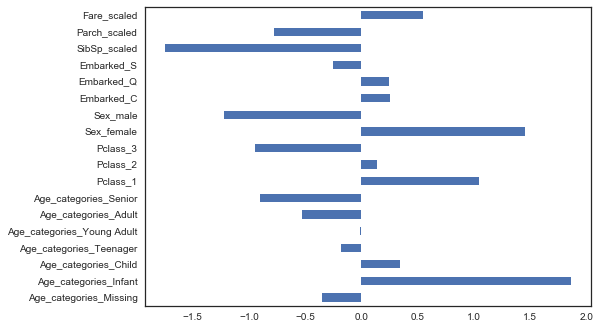

In [108]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'SibSp_scaled', 'Parch_scaled', 'Fare_scaled']

lr = LogisticRegression()
lr.fit(train[columns], train['Survived'])
coefficients = lr.coef_
feature_importance = pd.Series(coefficients[0], index=train[columns].columns)
feature_importance.plot.barh()
plt.show()

## 4. Training a model using relevant features. ##

In [109]:
from sklearn.model_selection import cross_val_score

columns = ['Age_categories_Infant', 'SibSp_scaled', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_3', 'Age_categories_Senior', 'Parch_scaled']

lr = LogisticRegression()
scores = cross_val_score(lr, train[columns], train['Survived'], cv=10)
accuracy = scores.mean()
print(accuracy)

0.814801952105


## 5. Submitting our Improved Model to Kaggle ##

In [110]:
columns = ['Age_categories_Infant', 'SibSp_scaled', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_3', 'Age_categories_Senior', 'Parch_scaled']

all_X = train[columns]
all_y = train['Survived']

lr = LogisticRegression()
lr.fit(all_X, all_y)
holdout_predictions = lr.predict(holdout[columns])

submission = pd.DataFrame({'PassengerId': holdout['PassengerId'], 'Survived': holdout_predictions})
submission.to_csv('submission_1.csv', index=False)


## 6. Engineering a New Feature Using Binning ##

In [111]:
def process_age(df,cut_points,label_names):
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

cut_points = [0, 12, 50, 100, 1000]
label_names = ['0-12', '12-50', '50-100', '100+']
train = process_age(train, cut_points, label_names)
holdout = process_age(holdout, cut_points, label_names)

train = create_dummies(train, 'Fare_categories')
holdout = create_dummies(holdout, 'Fare_categories')

In [112]:
## 7. Engineering Features From Text Columns ##

In [113]:
titles = {
    "Mr" :         "Mr",
    "Mme":         "Mrs",
    "Ms":          "Mrs",
    "Mrs" :        "Mrs",
    "Master" :     "Master",
    "Mlle":        "Miss",
    "Miss" :       "Miss",
    "Capt":        "Officer",
    "Col":         "Officer",
    "Major":       "Officer",
    "Dr":          "Officer",
    "Rev":         "Officer",
    "Jonkheer":    "Royalty",
    "Don":         "Royalty",
    "Sir" :        "Royalty",
    "Countess":    "Royalty",
    "Dona":        "Royalty",
    "Lady" :       "Royalty"
}

extracted_titles = train["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
train["Title"] = extracted_titles.map(titles)

extracted_titles = holdout['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
holdout['Title'] = extracted_titles.map(titles)

train['Cabin_type'] = train['Cabin'].str[0]
train['Cabin_type'] = train['Cabin_type'].fillna('Unknown')
holdout['Cabin_type'] = holdout['Cabin'].str[0]
holdout['Cabin_type'] = train['Cabin_type'].fillna('Unknown')

for col in ['Title', 'Cabin_type']:
    train = create_dummies(train, col)
    holdout = create_dummies(holdout, col)

## 8. Finding Correlated Features ##

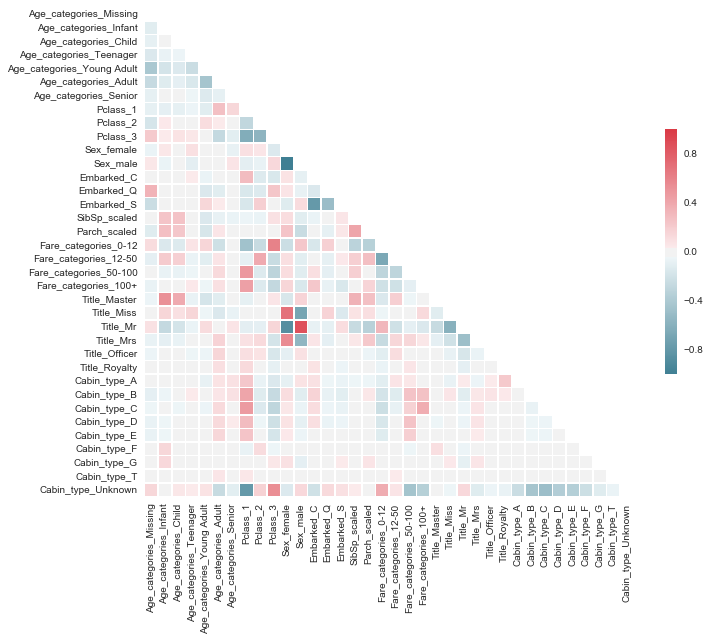

In [114]:
import numpy as np
import seaborn as sns

def plot_correlation_heatmap(df):
    corr = df.corr()
    
    sns.set(style="white")
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)


    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
    plt.show()

columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S',
       'SibSp_scaled', 'Parch_scaled', 'Fare_categories_0-12',
       'Fare_categories_12-50','Fare_categories_50-100', 'Fare_categories_100+',
       'Title_Master', 'Title_Miss', 'Title_Mr','Title_Mrs', 'Title_Officer',
       'Title_Royalty', 'Cabin_type_A','Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D',
       'Cabin_type_E','Cabin_type_F', 'Cabin_type_G', 'Cabin_type_T', 'Cabin_type_Unknown']

plot_correlation_heatmap(train[columns])

## 9. Final Feature Selection using RFECV ##

In [115]:
from sklearn.feature_selection import RFECV

columns = ['Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Age_categories_Senior', 'Pclass_1', 'Pclass_3',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'SibSp_scaled',
       'Parch_scaled', 'Fare_categories_0-12', 'Fare_categories_50-100',
       'Fare_categories_100+', 'Title_Miss', 'Title_Mr', 'Title_Mrs',
       'Title_Officer', 'Title_Royalty', 'Cabin_type_B', 'Cabin_type_C',
       'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_F', 'Cabin_type_G',
       'Cabin_type_T', 'Cabin_type_Unknown']

all_X = train[columns]
all_y = train["Survived"]

lr = LogisticRegression()
selector = RFECV(lr, cv=10)
selector.fit(all_X, all_y)
optimized_columns = all_X.columns[selector.support_]

## 10. Training A Model Using our Optimized Columns ##

In [116]:
all_X = train[optimized_columns]
all_y = train["Survived"]

lr = LogisticRegression()
scores = cross_val_score(lr, all_X, all_y, cv=10)
accuracy = scores.mean()
accuracy

0.82265491998638074

## 11. Submitting our Model to Kaggle ##

In [117]:
lr = LogisticRegression()
lr.fit(all_X, all_y)
holdout_predictions = lr.predict(holdout[optimized_columns])

submission = pd.DataFrame({'PassengerId': holdout['PassengerId'], 'Survived': holdout_predictions})
submission.to_csv('submission_2.csv', index=False)

In [127]:
train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')

# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [128]:
def clean_df(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    for col in ['Age_categories', 'Fare_categories', 'Title', 'Cabin_type', 'Sex']:    
        df = create_dummies(df, col)
    return df

train = clean_df(train)
holdout = clean_df(holdout)

In [129]:
def add_feature(df):
    df['isalone'] = df['SibSp']==0
    return df
train = add_feature(train)
holdout = add_feature(holdout)

In [130]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

def select_features(df):
    df = df.select_dtypes(include=['number'])
    df = df.dropna()
    all_X = df.drop(['PassengerId', 'Survived'], axis=1)
    all_y = df['Survived']
    rf = RandomForestClassifier()
    selector = RFECV(rf, cv=10)
    selector.fit(all_X, all_y)
    optimized_columns = all_X.columns[selector.support_]
    print(optimized_columns)
    return optimized_columns

best_features = select_features(train)


Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Adult',
       'Age_categories_Child', 'Age_categories_Infant',
       'Age_categories_Missing', 'Age_categories_Senior',
       'Age_categories_Teenager', 'Age_categories_Young Adult',
       'Fare_categories_0-12', 'Fare_categories_100+', 'Fare_categories_12-50',
       'Fare_categories_50-100', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_Officer', 'Cabin_type_A', 'Cabin_type_B',
       'Cabin_type_C', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_F',
       'Cabin_type_G', 'Cabin_type_Unknown', 'Sex_female', 'Sex_male'],
      dtype='object')


In [131]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

def select_model(df, features):
    all_X = df[features]
    all_y = df['Survived']
    
    models = []
    models.append( 
    {
        'name': 'LogisticRegression',
        'estimator': LogisticRegression(),
        'hyper_parameters':
        {
            'solver': ['newton-cg', 'lbfgs', 'liblinear']
        }
    })
    models.append(
    {
        'name': 'KNeighborsClassifier',
        'estimator': KNeighborsClassifier(),
        'hyper_parameters':
        {
            'n_neighbors': range(1, 20, 2),
            'weights': ['distance', 'uniform'],
            'algorithm': ["ball_tree", "kd_tree", "brute"],
            'p': [1,2]
        }
    })
    models.append(
    {
        'name': 'RandomForestClassifier',
        'estimator': RandomForestClassifier(),
        'hyper_parameters':
        {
            "n_estimators": [4, 6, 9],
            "criterion": ["entropy", "gini"],
            "max_depth": [2, 5, 10],
            "max_features": ["log2", "sqrt"],
            "min_samples_leaf": [1, 5, 8],
            "min_samples_split": [2, 3, 5]
        }
    })
    
    for model in models:
        print(model['name'])
        grid = GridSearchCV(model['estimator'], param_grid=model['hyper_parameters'], cv=10)
        grid.fit(all_X, all_y)
        model['best_estimator'] = grid.best_estimator_
        print(grid.best_params_)
        print(grid.best_score_)
    best_rf = grid.best_estimator_
    return models

best_models = select_model(train, best_features)

LogisticRegression
{'solver': 'liblinear'}
0.821548821549
KNeighborsClassifier
{'algorithm': 'brute', 'n_neighbors': 7, 'p': 1, 'weights': 'uniform'}
0.773288439955
RandomForestClassifier
{'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 6}
0.840628507295


In [135]:
all_X = train[best_features]
all_y = train['Survived']
accuracies = {}
for model in best_models:
    model['best_estimator'].fit(all_X, all_y)
    scores = cross_val_score(model['best_estimator'], all_X, all_y, cv=10)
    accuracy = scores.mean()
    accuracies[model['name']] = accuracy

print(accuracies)

{'LogisticRegression': 0.82164425150380205, 'KNeighborsClassifier': 0.77340341618431496, 'RandomForestClassifier': 0.82601265463625018}


In [134]:
def save_submission_file(models, columns, filename='untitled.csv'):
    for model in models:
        model['best_estimator'].fit(all_X, all_y)
        holdout_predictions = model['best_estimator'].predict(holdout[columns])
        submission = pd.DataFrame(
            {
                'PassengerID': holdout['PassengerId'],
                'Survived': holdout_predictions
            })
        submission.to_csv('submission_2'+model['name']+'.csv', index=False)
save_submission_file(best_models, best_features, filename='abc.csv')